Σημειώσεις:
- Η εργασία είναι ομαδική, με μέγιστο αριθμό ατόμων τα 2.
- Κάθε ομάδα θα πρέπει να παραδώσει ένα Google Colab notebook με τις λύσεις και τις επεξηγήσεις τους.
- Οι λύσεις θα ελεγχθούν ως προς την ομοιότητά τους (software wise).

# Task 1 - Προεργασία [0.25]

Στο παρόν task, πρέπει να λάβετε ένα occupancy grid map από το διαδίκτυο, να το φορτώσετε σε ένα αντικείμενο της OpenCV και να το εμφανίσετε σαν output.

- Παράδειγμα OGM: https://raw.githubusercontent.com/stdr-simulator-ros-pkg/stdr_simulator/indigo-devel/stdr_resources/maps/hospital_section.png 
- Σχόλια
  - Μπορείτε να χρησιμοποιήσετε την `skimage`.
  - Για να εμφανίσετε εικόνα στο Google colab πρέπει να χρησιμοποιήσετε το `from google.colab.patches import cv2_imshow`
  - Κάθε pixel της εικόνας θεωρούμε ότι έχει διάσταση 5x5 cm.

In [9]:
# Here make all the necessary imports
import cv2
import matplotlib.pyplot as plt

# from google.colab.patches import cv2_imshow

In [10]:
image = cv2.imread('./hospital_section.png')

# if image has 3 channels, convert it to grayscale and binarize it
def binarize(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Threshold the image to get the binary image
    _, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    return image

# if image has 3 channels, convert it to grayscale and inverse binarize it
def binarize_inv(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Getting the inverse binary threshold because the occupied area in picture is black so this is 0 but we want the occupied area to be 255(1) so we invert the threshold
    _, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)
    return image

    
# A function to show the image
def show_image(image, title, spacing=100):
    fig, ax = plt.subplots()
    plt.title(title)
    # ax show image
    ax.set_xticks([x for x in range(0, image.shape[1], spacing)])
    ax.set_xticklabels([5*x for x in range(0, image.shape[1], spacing)])
    ax.set_yticks([y for y in range(0, image.shape[0], spacing)])
    ax.set_yticklabels([5*y for y in range(0, image.shape[0], spacing)])
    ax.imshow(image, cmap='gray')


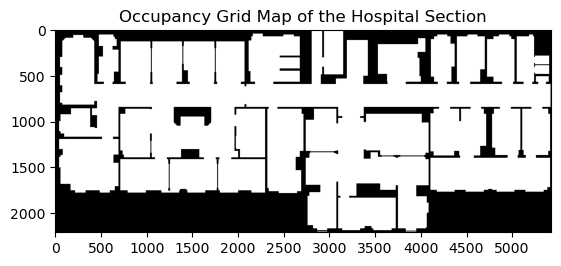

In [12]:
image_normal = binarize(image)
show_image(image_normal, title='Occupancy Grid Map of the Hospital Section')

# Task 2 - BrushFire [0.5]

Στο παρόν task, πρέπει να υπολογίσετε το brushfire value field του παραπάνω OGM, με τις εξής παραδοχές:
- Θα εφαρμόζεται στον ελεύθερο χώρο
- Θα ξεκινά από τα εμπόδια
- Θα τερματίζει όταν δεν θα μπορεί να εκτελέσει άλλη εξάπλωση

Καλείστε να δημιουργήσετε μία νέα εικόνα η οποία θα αναπαριστά το brushfire field και να την εμφανίσετε.

In [13]:
import numpy as np

In [14]:
# Brushfire Algorithm for a given image
def brushfire(image):
    # Create a copy of the image in order not to modify the original one
    image_copy = image.copy()
    # Get the dimensions of the image
    height, width = image_copy.shape
    # Create a numpy array of the same size as the image with all zeros in order to initialize the distance map
    distance = np.zeros((height, width), dtype=np.uint8)
    # Create a queue for the pixels that will be used later on to calculate the distances list
    queue = []
    
    # Loop through the image and add the pixels that are occupied to the queue
    for y in range(height):
        for x in range(width):
            # If the pixel is occupied, add it to the queue and assign it a distance of 1
            if image[y, x] == 255:
                queue.append((y, x))
                distance[y, x] = 1

    # Loop through the queue and add the pixels that are unoccupied to the queue
    while queue:
        # While we have data in the queue, pop the first element and assign it to y and x
        y, x = queue.pop(0)
        # Then for each of the 4 neighbors UP, DOWN, LEFT, RIGHT
        for dy, dx in ((-1, 0), (1, 0), (0, -1), (0, 1)):
            y2, x2 = y + dy, x + dx
            # Check if the neighbor is within the image regions and if the distance is 0 meaning that is not yet assigned proceed to the if statement
            if 0 <= y2 < height and 0 <= x2 < width and distance[y2, x2] == 0:
                # Assign the distance of the neighbor + 1
                distance[y2, x2] = distance[y, x] + 1
                # Add the neighbor to the queue in order to check its neighbors later on
                queue.append((y2, x2))

    # Finally return the distance map
    return distance

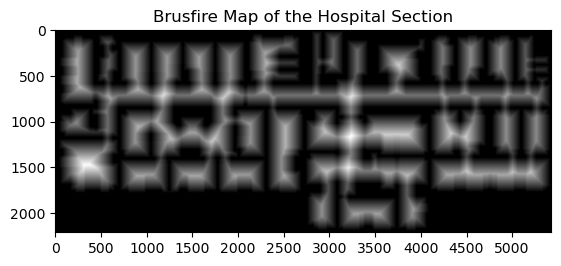

In [15]:
# We need to get the inverse here because the occupied regions have the 255 value in the image
inv_image = binarize_inv(image)
brushfire_map = brushfire(inv_image)
show_image(brushfire_map, 'Brusfire Map of the Hospital Section')

# Task 3 - Uniform PRM [0.5]

Υλοποιήστε ομοιόμορφη δειγματοληψία στον ελεύθερο χώρο, ούτως ώστε να δημιουργήσετε μία δομή γράφου, στην οποία θα μπορεί να εκτελεστεί αλγόριθμος αναζήτησης γράφου. Επίσης σχεδιάστε τον γράφο στην αρχική εικόνα και εμφανίστε τον.


In [19]:
# Create a class of a node that contains it's id, x and y coordinates and a list of neighbors
class Node:
  def __init__(self, id, x, y):
    self.id = id
    self.x = x
    self.y = y
    self.neighbors = [] # list of ids

# Create a graph class that contains a list of nodes
class Graph:
  def __init__(self):
    self.nodes = [] # list of Node instances

In [89]:
# Make a function than makes uniform sampling of points based on a given brushfire map and step size
def uniform_sampling(image, brushfire_map, step, threshold=1):
    # Initialize the graph
    graph = Graph()
    # Get the dimensions of the image
    height, width = image.shape
    # Create a counter for the ids of the nodes
    id_counter = 0
    # Loop through the image and add the points that are unoccupied to the list
    for x in range(0, width, step):
        for y in range(0, height, step):
            # If the pixel is unoccupied, add it to the list
            if image[y, x] > 1 and brushfire_map[y, x] > threshold:
                # Create a node instance
                current_node = Node(id_counter, x, y)
                # Increment id_counter
                id_counter += 1
                # Add the created node to the graph
                graph.nodes.append(current_node)
                # Now check for the neighbors of the node
                for di, dj in ((-step, 0), (-step, -step), (0, -step), (-step, +step)):
                    y2, x2 = y + di, x + dj
                    if 0 <= y2 < height and 0 <= x2 < width and image[y2, x2] > 1 and brushfire_map[y2, x2] > threshold:
                        # Search if the checked node is already in the graph and if it is add it to the neighbors list of the current node
                        for node in graph.nodes:
                            if node.x == x2 and node.y == y2:
                                current_node.neighbors.append(node)
                                break
                
    # Finally return the list of points
    return graph

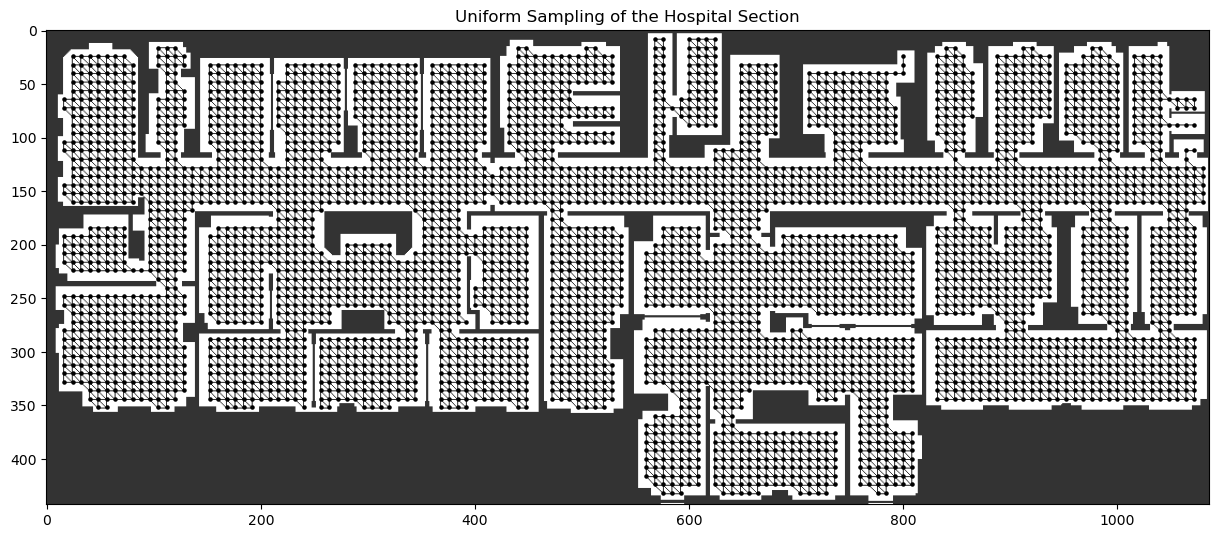

In [117]:
uniform_probalistic_roadmap = uniform_sampling(image_normal, brushfire_map, step=8, threshold=5)

x = []
y = []
for node in uniform_probalistic_roadmap.nodes:
    x.append(node.x)
    y.append(node.y)
        
plt.figure(figsize=(15,15))

# connect nodes with a white line if they are neighbors
        
plt.title('Uniform Sampling of the Hospital Section')
# plt.axis('off');
plt.scatter(x, y, s=5, c='black', marker='o');

# Draw the lines between the nodes
image_normal_copy = image_normal.copy()
for node in uniform_probalistic_roadmap.nodes:
    for neighbor in node.neighbors:
        cv2.line(image_normal_copy, (node.x, node.y+1), (neighbor.x, neighbor.y+1), (0,0,0), 1) 
        
plt.imshow(image_normal_copy, cmap='gray', alpha=0.8);
plt.show()

# Task 4 - Random PRM [0.5]

Υλοποιήστε τυχαία δειγματοληψία στον ελεύθερο χώρο, ούτως ώστε να δημιουργήσετε μία δομή γράφου, στην οποία θα μπορεί να εκτελεστεί αλγόριθμος αναζήτησης γράφου. Επίσης σχεδιάστε τον γράφο στην αρχική εικόνα και εμφανίστε τον.


In [72]:
# Make a function than makes random sampling of points based on a given brushfire map
def random_sampling(brushfire, num_samples, radius=5, threshold=1):
    # Initialize the graph
    graph = Graph()
    # Get the dimensions of the image
    height, width = brushfire.shape
    # Create a counter for the ids of the nodes
    id_counter = 0
    # Loop through the image and add the points that are unoccupied to the list
    for i in range(num_samples):
        # Get random x and y location on the image
        x = np.random.randint(0, width)
        y = np.random.randint(0, height)
        # Check if the random location it is not already got by another node
        flag_already_exists = False
        for node in graph.nodes:
            if node.x == x and node.y == y:
                flag_already_exists = True
        # If the pixel is unoccupied, add it to the list
        if (brushfire[y, x] > threshold) & (flag_already_exists == False):
            # Create a node instance
            current_node = Node(id_counter, x, y)
            # Increment id_counter
            id_counter += 1
            # Add the created node to the graph
            graph.nodes.append(current_node)
            # Now check for the neighbors of the node based on a given radius
            for node in graph.nodes:
                if np.sqrt((node.x - x)**2 + (node.y - y)**2) < radius:
                    current_node.neighbors.append(node)
                
    # Finally return the list of points
    return graph

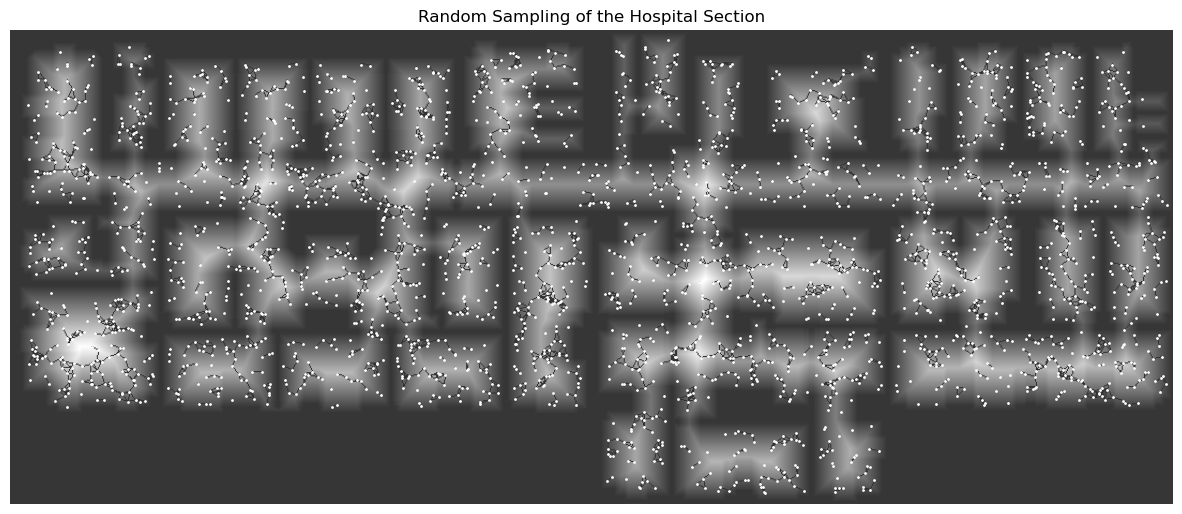

In [78]:
random_probalistic_roadmap = random_sampling(brushfire_map, num_samples=5000, radius=10, threshold=5)

x = []
y = []
for node in random_probalistic_roadmap.nodes:
    x.append(node.x)
    y.append(node.y)
    
plt.figure(figsize=(15,15))
plt.title('Random Sampling of the Hospital Section')
plt.axis('off');
plt.scatter(x, y, s=1, c='white', marker='o');

# Draw the lines between the nodes
image_normal_copy = brushfire_map.copy()
for node in random_probalistic_roadmap.nodes:
    for neighbor in node.neighbors:
        cv2.line(image_normal_copy, (node.x, node.y), (neighbor.x, neighbor.y), (0,0,200), 1) 
        
plt.imshow(image_normal_copy, cmap='gray', alpha=0.8);
plt.show()  

# Task 5 - Dijkstra & A* [0.75]

Υλοποιήστε τις συναρτήσεις `dijkstra` και `a_star` στην κλάση `Graph` οι οποίες θα λαμβάνουν ως όρισμα δύο κόμβους του γράφου και θα επιστρέφουν:
- Το μονοπάτι από τον έναν στον άλλον κόμβο
- Τα expansions (searches) που έγιναν κατά την αναζήτηση

Επίσης σχεδιάστε το μονοπάτι στην αρχική εικόνα και εμφανίστε το.

# Task 6 - RRT [0.75]

Έχοντας ως είσοδο δύο κόμβους του γράφου, υλοποιήστε τον αλγόριθμο RRT, ο οποίος θα πρέπει να επιστρέφει το μονοπάτι από τον ένα κόμβο προς τον άλλον. Επίσης σχεδιάστε το RRT στην αρχική εικόνα και εμφανίστε το.

# Task 7 - RRT* [0.5]

Έχοντας ως είσοδο δύο κόμβους του γράφου, υλοποιήστε τον αλγόριθμο `RRT*`, ο οποίος θα πρέπει να επιστρέφει το μονοπάτι από τον ένα κόμβο προς τον άλλον. Επίσης σχεδιάστε το `RRT*` στην αρχική εικόνα και εμφανίστε το.

Σχόλιο: Εκτελέστε 2N επαναλήψεις, όπου Ν ο αριθμός επαναλήψεων κατά τον οποίο βρέθηκε ο στόχος.

# Task 8 - Path smoothing [0.25]

Έχοντας ως είσοδο ένα μονοπάτι, υλοποιήστε μέθοδο που θα το ομαλοποιεί με χρήση της μεθόδου gradient descent (ή όποιας άλλης επιθυμείτε). Στο τέλος, θα πρέπει να δείξετε το αρχικό μονοπάτι και το smoothed.